In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import sys
import csv
import seaborn as sb
from collections import OrderedDict
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score
from transformers import BertTokenizer
import torch
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from bertopic import BERTopic


## Bertopic GPU
from bertopic import BERTopic
from cuml.cluster import HDBSCAN
from cuml.manifold import UMAP

import time

In [2]:
csv.field_size_limit(sys.maxsize)
nltk.download('stopwords')
nltk.download('punkt')
stop_words = stopwords.words("english")


[nltk_data] Downloading package stopwords to /home/csongi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/csongi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [4]:
news_data = pd.read_csv('WELFake_Dataset.csv', engine='python', encoding='utf-8', on_bad_lines='skip').fillna('')

news_data_smaller = news_data.sample(n=10000).reset_index(drop=True)

In [5]:
def remove_punctuation(some_string):
    unpuncted_string = some_string.translate(str.maketrans("","",string.punctuation))
    unpuncted_string = unpuncted_string.translate(str.maketrans("","","—"))
    return(unpuncted_string)

In [6]:
def apply_stemming(some_string):
    new_list = []
    for word in some_string.split():
        word = stemmer.stem(word)
        new_list.append(word)
    return(new_list)

In [7]:
#Remove for definite run
news_data = news_data_smaller

In [8]:
news_data["title_clean"] = news_data["title"].apply(lambda x: " ".join([word for word in str(x).lower().split() if word not in (stop_words)]))
news_data["title_clean"] = news_data["title_clean"].apply(remove_punctuation)
news_data["title_clean"] = news_data["title_clean"].apply(apply_stemming)


In [9]:
news_data["text_clean"] = news_data["text"].apply(lambda x: " ".join([word for word in str(x).lower().split() if word not in (stop_words)]))
news_data["text_clean"] = news_data["text_clean"].apply(remove_punctuation)
news_data["text_clean"] = news_data["text_clean"].apply(apply_stemming)

In [10]:
news_data

,Unnamed: 0,title,text,label,title_clean,text_clean
0,48267,Elon Musk to Completely Revolutionize the Ener...,Home / Be The Change / Elon Musk to Completely...,1,"[elon, musk, complet, revolution, energi, indu...","[home, chang, elon, musk, complet, revolution,..."
1,56806,WOW! Why George W. Bush Never Left DC Until Af...,"Meanwhile, the Obama s jet off to Hawaii every...",1,"[wow, georg, w, bush, never, left, dc, christm...","[meanwhil, obama, jet, hawaii, everi, year, we..."
2,19541,Al Shabaab bomb kills 12 in Somalia's Puntland,"BOSSASO, Somalia (Reuters) - An al Shabaab bom...",0,"[al, shabaab, bomb, kill, 12, somalia, puntland]","[bossaso, somalia, reuter, al, shabaab, bomb, ..."
3,56075,FRESHMAN ORIENTATION: It’s Racist To Ask Asian...,You know the Left has won when communism repla...,1,"[freshman, orient, it, racist, ask, asian, stu...","[know, left, communism, replac, educ, freshman..."
4,24926,Lawsuit claims Trump travel ban discriminates ...,(Reuters) - The American Civil Liberties Union...,0,"[lawsuit, claim, trump, travel, ban, discrimin...","[reuter, american, civil, liberti, union, accu..."
...,...,...,...,...,...,...
9995,3835,A Latina Disney Movie Princess? The Wait Isn’t...,I’m not part of Disney’s target audience for i...,0,"[latina, disney, movi, princess, wait, isn't, ...","[i'm, part, disney, target, audienc, latest, p..."
9996,26910,Death Toll From Brazil Prison Riot Reaches 26 ...,RIO DE JANEIRO — The death toll from a riot...,0,"[death, toll, brazil, prison, riot, reach, 26,...","[rio, de, janeiro, death, toll, riot, penitent..."
9997,23457,Bernie Bursts Out Laughing After Trump Unknow...,Hours after helping begin to repeal America s ...,1,"[berni, burst, laugh, trump, unknow, prais, au...","[hour, help, begin, repeal, america, univers, ..."
9998,39573,Texas lawyer sues Cruz to challenge eligibility,NEW YORK (Reuters) - A Texas lawyer has filed ...,0,"[texa, lawyer, sue, cruz, challeng, elig]","[new, york, reuter, texa, lawyer, file, first,..."


In [11]:
def calculate_word_occurences(text, labels):
  occurence = {}
  occurence_in_fake_articles = {}
  occurence_in_real_articles = {}
  for sentence, label in zip(news_data["text_clean"], news_data["label"]):
    for word in sentence:
      if label == 1:
        if word in occurence_in_real_articles:
          occurence_in_real_articles[word] += 1
        else:
          occurence_in_real_articles[word] = 1
      else:
        if word in occurence_in_fake_articles:
          occurence_in_fake_articles[word] += 1
        else:
          occurence_in_fake_articles[word] = 1


      if word in occurence:
        occurence[word] += 1
      else:
        occurence[word] = 1

  occurence = dict(sorted(occurence.items(), key=lambda item: item[1], reverse=True))
  occurence_in_fake_articles = dict(sorted(occurence_in_fake_articles.items(), key=lambda item: item[1], reverse=True))
  occurence_in_real_articles = dict(sorted(occurence_in_real_articles.items(), key=lambda item: item[1], reverse=True))
  
  return occurence, occurence_in_fake_articles, occurence_in_real_articles

In [12]:
word_occurence, occurrence_fake, occurrence_real = calculate_word_occurences(news_data["text_clean"], news_data["label"])

word_occurence_top = {k: word_occurence[k] for k in list(word_occurence)[:10]}

occurrence_real, occurrence_fake

({'trump': 14261,
  'us': 6701,
  'said': 6658,
  'peopl': 6631,
  'clinton': 6473,
  'one': 6264,
  'would': 6047,
  'state': 5932,
  'presid': 5675,
  'like': 5224,
  'time': 4796,
  'hillari': 4544,
  'say': 4443,
  'american': 4124,
  'go': 4112,
  'year': 3931,
  'also': 3920,
  'new': 3867,
  'even': 3860,
  'report': 3823,
  'obama': 3742,
  'make': 3731,
  'get': 3678,
  'use': 3571,
  'elect': 3478,
  'donald': 3463,
  'support': 3348,
  'it': 3296,
  'know': 3219,
  'nation': 3155,
  'news': 3030,
  'right': 2983,
  'govern': 2971,
  'call': 2963,
  'republican': 2944,
  'want': 2833,
  'work': 2831,
  'could': 2831,
  'vote': 2807,
  'mani': 2806,
  'think': 2803,
  'take': 2776,
  'countri': 2770,
  'campaign': 2758,
  'democrat': 2736,
  'polit': 2734,
  'media': 2706,
  'world': 2672,
  'come': 2624,
  'white': 2624,
  'day': 2578,
  'way': 2517,
  'see': 2424,
  'hous': 2417,
  'first': 2413,
  'show': 2398,
  'america': 2342,
  'back': 2302,
  'need': 2243,
  'thing': 2

In [13]:
def generate_plot_data(word_occurences, occurence_in_fake_articles, occurence_in_real_articles):
  words_x = []
  words_fake = []
  words_real = []

  for word in word_occurences:
    if (word not in occurence_in_fake_articles):
      words_fake.append(0)
    else:
      words_fake.append(occurence_in_fake_articles[word])

    if (word not in occurence_in_real_articles):
      words_real.append(0)
    else:
      words_real.append(occurence_in_real_articles[word])

    words_x.append(word)
    
  return words_x, words_fake, words_real

In [14]:
news_data["label"].value_counts()

1    5161
0    4839
Name: label, dtype: int64

<BarContainer object of 2 artists>

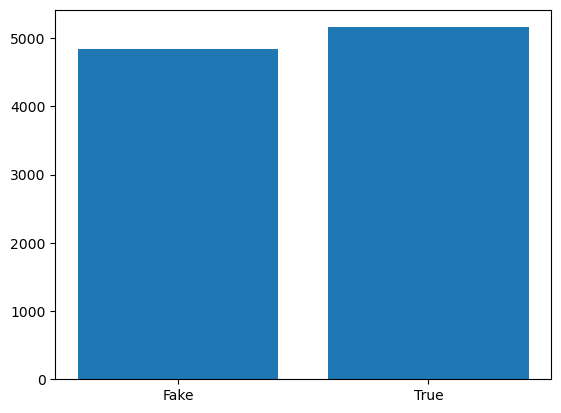

In [15]:
x = np.array(["Fake", "True"])
y = np.array([news_data['label'].value_counts()[0], news_data['label'].value_counts()[1]])

plt.bar(x,y)

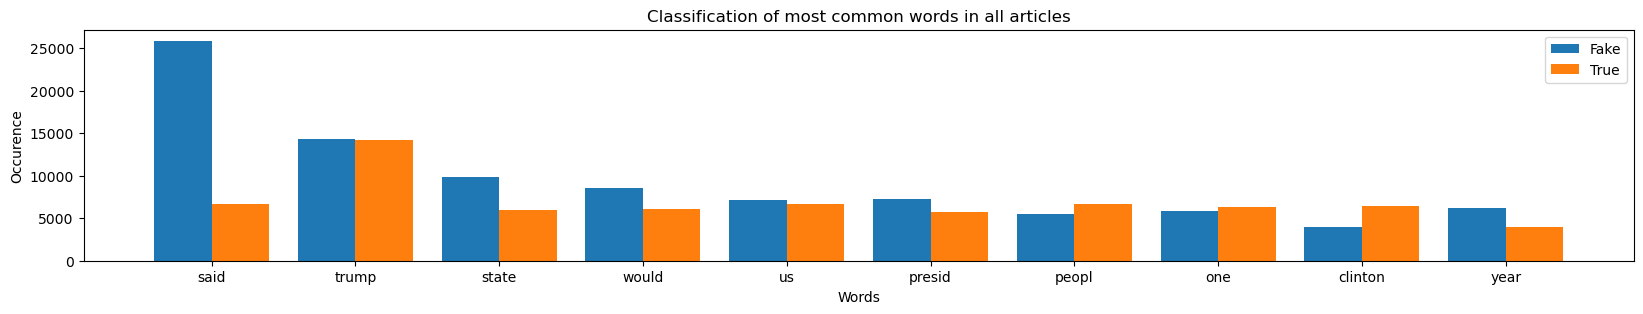

In [16]:
words_x, words_fake, words_true = generate_plot_data(word_occurence_top, occurrence_fake, occurrence_real)
X_axis = np.arange(len(words_x))
plt.figure(figsize=(20, 3)) 
plt.bar(X_axis - 0.2, words_fake, 0.4, label = 'Fake')
plt.bar(X_axis + 0.2, words_true, 0.4, label = 'True')


plt.xticks(X_axis, words_x)
plt.xlabel("Words")
plt.ylabel("Occurence")
plt.title("Classification of most common words in all articles")
plt.legend()
plt.show()

In [17]:
def bow_maker(some_list):
    bow = set()
    for word in some_list:
        numbr = some_list.count(word)
        bow.add((word, numbr))
    return(bow)

print(news_data["title_clean"].apply(bow_maker)[0])

{('new', 1), ('musk', 1), ('solar', 1), ('roof', 1), ('revolution', 1), ('industri', 1), ('complet', 1), ('energi', 1), ('tesla', 1), ('elon', 1)}


In [18]:
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(some_text):
    vs = analyzer.polarity_scores(some_text)
    return vs["compound"]

def pos_neg(sentiment_score):
    if sentiment_score <= -0.05:
        sent = "neg"
        if sentiment_score <= -0.6:
            sent = "very negative"
    elif sentiment_score >= 0.05:
        sent = "pos"
        if sentiment_score >= 0.6:
            sent = "very positive"
    else:
        sent = "neut"
    return sent

In [19]:
news_data["title_sentiment_score"] = news_data["title"].apply(get_sentiment)
news_data["title_sentiment"] = news_data["title_sentiment_score"].apply(pos_neg)
news_data["text_sentiment_score"] = news_data["text"].apply(get_sentiment)
news_data["text_sentiment"] = news_data["text_sentiment_score"].apply(pos_neg)

In [20]:
docs = news_data["text"].to_list()
start = time.time()
## GPU
# Create instances of GPU-accelerated UMAP and HDBSCAN
umap_model = UMAP(n_components=5, n_neighbors=15, min_dist=0.0)
hdbscan_model = HDBSCAN(min_samples=10, gen_min_span_tree=True)

# Pass the above models to be used in BERTopic
topic_model = BERTopic(umap_model=umap_model, hdbscan_model=hdbscan_model)
topics, probs = topic_model.fit_transform(docs)

## CPU

#topic_model = BERTopic()

#topics, probs = topic_model.fit_transform(docs)

In [21]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,4370,-1_the_and_of_to
1,0,233,0_obamacare_health_insurance_care
2,1,146,1_fbi_emails_clinton_email
3,2,144,2_police_officers_officer_was
4,3,132,3_climate_energy_change_coal
...,...,...,...
156,155,5,155_fpo_kurz_farright_austria
157,156,5,156_qatar_sheikh_arab_bahrain
158,157,5,157_kelly_megyn_fox_leeds
159,158,5,158_muslims_burqa_britain_terrorism


In [22]:
end = time.time()
print(end - start)

59.983696699142456


In [23]:
topics_df = pd.DataFrame({"topic": topics})
news_data["topic"] = topics

In [24]:
news_data

,Unnamed: 0,title,text,label,title_clean,text_clean,title_sentiment_score,title_sentiment,text_sentiment_score,text_sentiment,topic
0,48267,Elon Musk to Completely Revolutionize the Ener...,Home / Be The Change / Elon Musk to Completely...,1,"[elon, musk, complet, revolution, energi, indu...","[home, chang, elon, musk, complet, revolution,...",0.3321,pos,0.9974,very positive,-1
1,56806,WOW! Why George W. Bush Never Left DC Until Af...,"Meanwhile, the Obama s jet off to Hawaii every...",1,"[wow, georg, w, bush, never, left, dc, christm...","[meanwhil, obama, jet, hawaii, everi, year, we...",0.7027,very positive,0.8805,very positive,-1
2,19541,Al Shabaab bomb kills 12 in Somalia's Puntland,"BOSSASO, Somalia (Reuters) - An al Shabaab bom...",0,"[al, shabaab, bomb, kill, 12, somalia, puntland]","[bossaso, somalia, reuter, al, shabaab, bomb, ...",-0.7717,very negative,-0.9899,very negative,-1
3,56075,FRESHMAN ORIENTATION: It’s Racist To Ask Asian...,You know the Left has won when communism repla...,1,"[freshman, orient, it, racist, ask, asian, stu...","[know, left, communism, replac, educ, freshman...",-0.8233,very negative,-0.9870,very negative,14
4,24926,Lawsuit claims Trump travel ban discriminates ...,(Reuters) - The American Civil Liberties Union...,0,"[lawsuit, claim, trump, travel, ban, discrimin...","[reuter, american, civil, liberti, union, accu...",-0.6705,very negative,0.8444,very positive,-1
...,...,...,...,...,...,...,...,...,...,...,...
9995,3835,A Latina Disney Movie Princess? The Wait Isn’t...,I’m not part of Disney’s target audience for i...,0,"[latina, disney, movi, princess, wait, isn't, ...","[i'm, part, disney, target, audienc, latest, p...",0.0000,neut,0.9987,very positive,-1
9996,26910,Death Toll From Brazil Prison Riot Reaches 26 ...,RIO DE JANEIRO — The death toll from a riot...,0,"[death, toll, brazil, prison, riot, reach, 26,...","[rio, de, janeiro, death, toll, riot, penitent...",-0.8910,very negative,-0.9999,very negative,10
9997,23457,Bernie Bursts Out Laughing After Trump Unknow...,Hours after helping begin to repeal America s ...,1,"[berni, burst, laugh, trump, unknow, prais, au...","[hour, help, begin, repeal, america, univers, ...",0.8689,very positive,0.9974,very positive,0
9998,39573,Texas lawyer sues Cruz to challenge eligibility,NEW YORK (Reuters) - A Texas lawyer has filed ...,0,"[texa, lawyer, sue, cruz, challeng, elig]","[new, york, reuter, texa, lawyer, file, first,...",0.0772,pos,-0.4492,neg,11


In [25]:
topic_model.get_topic(6)

[('korea', 0.05072448154048476),
 ('north', 0.04697786063976976),
 ('korean', 0.026283083700679458),
 ('missile', 0.02168676162260868),
 ('nuclear', 0.018265502620184206),
 ('south', 0.017259861299896005),
 ('pyongyang', 0.016722593586065704),
 ('kim', 0.014207917268309635),
 ('japan', 0.011337035696350717),
 ('test', 0.010491829372628795)]

In [26]:
fake_mask = news_data['label'].isin([0])
fake_news_df = news_data[fake_mask]
fake_news_topics = set(fake_news_df['topic'].values)
print(len(fake_news_topics))

150


In [27]:
true_mask = news_data['label'].isin([1])
true_news_df = news_data[true_mask]
true_news_topics = set(true_news_df['topic'].values)
print(len(true_news_topics))

151


In [28]:
only_fake_topics = fake_news_topics.difference(true_news_topics)
only_true_topics = true_news_topics.difference(fake_news_topics)

In [29]:
only_fake_topics

{27, 45, 74, 82, 89, 96, 117, 134, 155, 156}

In [30]:
only_true_topics

{21, 54, 77, 92, 100, 112, 123, 129, 147, 149, 154}

In [31]:
def count_dict(some_df, column_name, value_list):
    dic = {}
    for value in value_list:
        if value in some_df[column_name].values:
            count = some_df[column_name].value_counts()[value]
            dic[value] = count
        else:
            continue
    return dic


In [32]:
count_dict(fake_news_df, "topic", list(only_fake_topics))

{96: 19,
 134: 11,
 74: 26,
 155: 5,
 45: 42,
 82: 23,
 117: 15,
 89: 21,
 27: 55,
 156: 5}

In [33]:
print(f"The mean sentiment score for fake news titles is {fake_news_df['title_sentiment_score'].mean()}, while the mean sentiment score for fake news texts is {fake_news_df['text_sentiment_score'].mean()}")
print(f"The mean sentiment score for true news titles is {true_news_df['title_sentiment_score'].mean()}, while the mean sentiment score for true news texts is {true_news_df['text_sentiment_score'].mean()}")

The mean sentiment score for fake news titles is -0.08115302748501758, while the mean sentiment score for fake news texts is 0.09509129985534202
The mean sentiment score for true news titles is -0.13842978105018405, while the mean sentiment score for true news texts is -0.02301521023057547


In [34]:
print(f"The median for sentiment scores in fake news titles is {fake_news_df['title_sentiment_score'].median()}, while the median for sentiment scores in fake news texts is {fake_news_df['text_sentiment_score'].median()}")
print(f"The median for sentiment scores in true news titles is {true_news_df['title_sentiment_score'].median()}, while the median for sentiment scores in fake news texts is {true_news_df['text_sentiment_score'].median()}")

The median for sentiment scores in fake news titles is 0.0, while the median for sentiment scores in fake news texts is 0.4019
The median for sentiment scores in true news titles is 0.0, while the median for sentiment scores in fake news texts is 0.0


In [35]:
fake_news_df["title_sentiment"].value_counts(), true_news_df["title_sentiment"].value_counts()

(neut             1799
 neg              1385
 pos              1001
 very negative     480
 very positive     174
 Name: title_sentiment, dtype: int64,
 neut             1497
 neg              1464
 very negative     955
 pos               947
 very positive     298
 Name: title_sentiment, dtype: int64)

In [36]:
fake_news_df["text_sentiment"].value_counts(), true_news_df["text_sentiment"].value_counts()

(very positive    2230
 very negative    1764
 pos               416
 neg               343
 neut               86
 Name: text_sentiment, dtype: int64,
 very negative    2134
 very positive    2036
 pos               375
 neg               361
 neut              255
 Name: text_sentiment, dtype: int64)

In [37]:
topics_list = news_data["topic"].unique().tolist()
all_topics = count_dict(news_data, "topic", topics_list)
all_fake_topics = count_dict(fake_news_df, "topic", topics_list)
all_true_topics = count_dict(true_news_df, "topic", topics_list)
divisive_topics = []
for topic in topics_list:
    if topic in only_true_topics:
        divisive_topics.append(topic)
    elif all_fake_topics[topic]/all_topics[topic] > 0.8:
        divisive_topics.append(topic)
    elif all_true_topics[topic]/all_topics[topic] > 0.8:
        divisive_topics.append(topic)

shared_topics = np.setdiff1d(topics_list, divisive_topics)

In [38]:
len(divisive_topics), len(topics_list), len(shared_topics)

(74, 161, 87)

In [39]:
count_dict(news_data, "topic", list(shared_topics))

{-1: 4370,
 0: 233,
 1: 146,
 2: 144,
 3: 132,
 8: 102,
 9: 91,
 11: 88,
 12: 87,
 13: 83,
 14: 82,
 15: 81,
 16: 80,
 18: 76,
 19: 71,
 20: 70,
 22: 63,
 23: 59,
 24: 59,
 25: 59,
 26: 59,
 28: 55,
 31: 51,
 32: 49,
 33: 49,
 34: 48,
 35: 47,
 36: 47,
 39: 45,
 40: 44,
 44: 42,
 49: 38,
 51: 37,
 52: 34,
 56: 33,
 60: 31,
 61: 31,
 62: 31,
 63: 31,
 65: 31,
 66: 30,
 67: 30,
 70: 27,
 71: 27,
 72: 27,
 73: 26,
 76: 25,
 79: 24,
 81: 23,
 83: 23,
 84: 22,
 85: 22,
 86: 21,
 87: 21,
 88: 21,
 90: 21,
 93: 20,
 95: 20,
 97: 19,
 99: 19,
 101: 19,
 102: 19,
 103: 18,
 105: 18,
 108: 18,
 109: 17,
 110: 17,
 115: 16,
 116: 16,
 119: 15,
 121: 15,
 125: 14,
 127: 13,
 128: 13,
 130: 12,
 133: 12,
 137: 11,
 138: 10,
 140: 9,
 141: 9,
 145: 7,
 146: 7,
 151: 6,
 153: 6,
 157: 5,
 158: 5,
 159: 5}

In [40]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [41]:
tokenizer.encode_plus(texts[1])

NameError: name 'texts' is not defined

In [ ]:
tokenizer.encode(texts[2])

In [ ]:
texts = news_data["title"].values
labels = news_data['label'].values

In [ ]:
texts

In [ ]:
def tokenize_map(sentence, labs='None'):
    global labels
    input_ids = []
    attention_masks = []
    for text in sentence:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens = True, # [CLS] & [SEP]
                            truncation = 'longest_first', # Control truncation
                            max_length = 100, # Max length about texts
                            pad_to_max_length = True, # Pad and truncate about sentences
                            return_attention_mask = True, # Attention masks
                            return_tensors = 'pt') # Return to pytorch tensors
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    if labs != 'None':
        labels = torch.tensor(labels)
        return input_ids, attention_masks, labels
    else:
        return input_ids, attention_masks

In [ ]:
input_ids, attention_masks, labels = tokenize_map(texts, labels)

In [ ]:
labels

In [ ]:
input_ids, attention_masks

In [ ]:
word_frequency = {}
wordPerLine = {}
allwordsAmount = {}
allTokens = []
counter = 0
for line in news_data["text"]:
    #print(line)
    for token in line:
        if token not in wordPerLine.keys():
            wordPerLine[token] = 1
            allwordsAmount[token] = 1
            if token not in allTokens:
              allTokens.append(token)
        else:
            wordPerLine[token] += 1
            allwordsAmount[token] += 1
    word_frequency[counter] = wordPerLine
    wordPerLine = {}
    counter = counter +1

bowResults = []
for line in news_data["text"]:
    vector=[]
    for w in allTokens:
        vector.append(line.count(w))
    print(vector)
    bowResults.append(vector) 